# DPU Example: YOLOv5 with Image, Video, and Webcam

<hr style="height:1px; border:none; background-color:#999; margin:20px 0;" />

## Aim/s
This notebook demonstrates how to use a compiled YOLOv5 model on a Xilinx DPU
accelerator (Vitis-AI), supporting:
- Static image inference
- Video file inference
- Real-time inference from webcam

## References
- [Vitis AI GitHub Repository](https://github.com/Xilinx/Vitis-AI)
- YOLOv5 model from Ultralytics (converted to `.xmodel` for DPU)

## Last revised
- July 16, 2025
  - Initial version for YOLOv5 + image/video/webcam


<hr style="height:1px; border:none; background-color:#999; margin:20px 0;" />

### 🔌 Load the DPU Overlay

To begin using the Xilinx DPU accelerator on your PYNQ board, we first **load the DPU bitstream**.

This bitstream contains the hardware logic for executing deep learning models (compiled `.xmodel` files) using Vitis AI.

> **Note:** Make sure your `dpu.bit` file is already compiled and available in your working directory.
We will load the DPU bitstream onto the PYNQ board.

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 98.8879MHz.
  warnings.warn(


### 🛠 Import Required Libraries

We begin by importing the necessary Python libraries for:

- **OS & time**: file and time operations
- **NumPy**: numerical operations
- **OpenCV (cv2)**: image/video I/O and processing
- **Matplotlib**: plotting and drawing bounding boxes
- **IPython.display**: dynamic display in notebooks
- **colorsys & random**: generating distinct colors for classes
- **PIL**: optional image utilities

In this section, we will prepare a few functions for later use.

In [2]:
import os
import time
import numpy as np
import cv2
import random
import colorsys
from matplotlib.patches import Rectangle
from IPython import display
import matplotlib.pyplot as plt
from PIL import Image

The load_model() method will automatically prepare the graph which is used by VART.

Note For the PYNQ-ZU board you may see TLS memory allocation errors if cv2 gets loaded before loading the vitis libraries in the Jupyter Lab environment. Make sure to load cv2 first in these cases.

In [3]:
overlay.load_model("./xmodel/yolov5.xmodel")

### 🔧 Preprocessing and Anchor Definition
Let's begin by defining a few essential preprocessing utilities, including the anchor box configuration.\
The anchor_list should match the anchor values used during training, as these are crucial for correctly decoding YOLO predictions.

In [4]:
# Define the anchor boxes used during training
anchor_list = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]

# Convert to floating-point and reshape into (num_anchors, 2)
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)

✅ Make sure the anchor values and their order are consistent with your original training configuration (e.g., from `data.yaml` or training script).
Incorrect anchors may cause significant accuracy drop during inference.

### 📄 Load Class Labels
We now load the class labels used during training.\
The file (e.g., `cat_dog_classes.txt`) should contain one class name per line.

In [5]:
# Load class names from a plain text file
def get_class(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

# Example: loading a two-class model (cat and dog)
classes_path = "img/cat_dog_classes.txt"
class_names = get_class(classes_path)
num_classes = len(class_names)


📌 Make sure the class file exactly matches the order used during training.
For example:

`cat`\
`dog`

### 🎨 Assign Unique Colors to Each Class
To visualize detection results more clearly, we assign a unique RGB color to each class label using the HSV color space.\
This ensures that adjacent classes have distinguishable colors, and shuffling helps to randomize their order.

In [6]:
# Generate N evenly spaced HSV colors and convert to RGB
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: 
                  (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), 
                  colors))

# Shuffle to avoid similar adjacent colors
random.seed(0)
random.shuffle(colors)
random.seed(None)

🎯 This `colors`list will later be used to draw bounding boxes in consistent but visually distinctive colors for each class.

### 🧪 Preprocessing: Resize with Padding and Normalize
Before feeding the image to the DPU, we apply a preprocessing pipeline that:

- Converts BGR to RGB

- Resizes the image to a target shape while preserving aspect ratio using letterbox padding

- Normalizes pixel values to `[0, 1]` as `float32`

- Adds a batch dimension (i.e., `(1, H, W, 3)`)



In [7]:
# Resize image with unchanged aspect ratio using padding
def letterbox_image(image, size):
    ih, iw, _ = image.shape
    w, h = size
    scale = min(w/iw, h/ih)
    
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = cv2.resize(image, (nw,nh), interpolation=cv2.INTER_LINEAR)
    new_image = np.ones((h,w,3), np.uint8) * 128
    h_start = (h-nh)//2
    w_start = (w-nw)//2
    new_image[h_start:h_start+nh, w_start:w_start+nw, :] = image
    return new_image


# Full preprocessing pipeline for inference
def pre_process(image, model_image_size):
    image = image[...,::-1]
    image_h, image_w, _ = image.shape
 
    if model_image_size != (None, None):
        assert model_image_size[0]%32 == 0, 'Multiples of 32 required'
        assert model_image_size[1]%32 == 0, 'Multiples of 32 required'
        boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    else:
        new_image_size = (image_w - (image_w % 32), image_h - (image_h % 32))
        boxed_image = letterbox_image(image, new_image_size)
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # add batch dimension
    return image_data


📌 The letterbox technique ensures that the aspect ratio is preserved, preventing distortion while fitting the input to the model’s required size (e.g., 640×640).

### 📦 Decode YOLO Outputs into Bounding Boxes

The following functions take raw YOLO feature maps and decode them into final bounding boxes and class scores.

- `_get_feats()`: Applies sigmoid/exp decoding to extract box centers, sizes, confidence, and class probabilities.
- `correct_boxes()`: Maps model-space coordinates back to the original image space, considering letterbox padding.
- `boxes_and_scores()`: Combines the outputs into flattened `boxes` and `scores` for later use in NMS filtering.

In [8]:
def _get_feats(feats, anchors, num_classes, input_shape):
    num_anchors = len(anchors)
    anchors_tensor = np.reshape(np.array(anchors, dtype=np.float32), [1, 1, 1, num_anchors, 2])
    grid_size = np.shape(feats)[1:3]
    nu = num_classes + 5
    predictions = np.reshape(feats, [-1, grid_size[0], grid_size[1], num_anchors, nu])
    grid_y = np.tile(np.reshape(np.arange(grid_size[0]), [-1, 1, 1, 1]), [1, grid_size[1], 1, 1])
    grid_x = np.tile(np.reshape(np.arange(grid_size[1]), [1, -1, 1, 1]), [grid_size[0], 1, 1, 1])
    grid = np.concatenate([grid_x, grid_y], axis = -1)
    grid = np.array(grid, dtype=np.float32)

    box_xy = (1/(1+np.exp(-predictions[..., :2])) + grid) / np.array(grid_size[::-1], dtype=np.float32)
    box_wh = np.exp(predictions[..., 2:4]) * anchors_tensor / np.array(input_shape[::-1], dtype=np.float32)
    box_confidence = 1/(1+np.exp(-predictions[..., 4:5]))
    box_class_probs = 1/(1+np.exp(-predictions[..., 5:]))
    return box_xy, box_wh, box_confidence, box_class_probs


def correct_boxes(box_xy, box_wh, input_shape, image_shape):
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = np.array(input_shape, dtype = np.float32)
    image_shape = np.array(image_shape, dtype = np.float32)
    new_shape = np.around(image_shape * np.min(input_shape / image_shape))
    offset = (input_shape - new_shape) / 2. / input_shape
    scale = input_shape / new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes = np.concatenate([
        box_mins[..., 0:1],
        box_mins[..., 1:2],
        box_maxes[..., 0:1],
        box_maxes[..., 1:2]
    ], axis = -1)
    boxes *= np.concatenate([image_shape, image_shape], axis = -1)
    return boxes


def boxes_and_scores(feats, anchors, classes_num, input_shape, image_shape):
    box_xy, box_wh, box_confidence, box_class_probs = _get_feats(feats, anchors, classes_num, input_shape)
    boxes = correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = np.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = np.reshape(box_scores, [-1, classes_num])
    return boxes, box_scores

### 🧠 Postprocessing & Visualization

Once the DPU returns raw output tensors from the YOLOv5 model, we need to decode, filter, and visualize the results.

#### `draw_boxes_to_image(image, boxes, scores, classes)`
Draws bounding boxes and class labels on an image using `matplotlib`, with color-coded boxes per class.

#### `nms_boxes(boxes, scores, iou_threshold)`
Implements Non-Maximum Suppression (NMS) to remove redundant overlapping boxes, keeping the most confident ones.

#### `evaluate(...)`
1. Decodes multi-scale YOLO outputs into bounding boxes and scores.
2. Applies class-wise confidence filtering.
3. Applies NMS per class.
4. Returns final `boxes`, `scores`, and `classes`.

In [9]:
def draw_boxes_to_image(image, boxes, scores, classes, figsize=(12, 12)):
    import io
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_h, image_w, _ = image.shape

    for i, bbox in enumerate(boxes):
        [top, left, bottom, right] = bbox
        width, height = right - left, bottom - top
        score, class_index = scores[i], classes[i]
        label = '{}: {:.4f}'.format(class_names[class_index], score)
        color = tuple([c/255 for c in colors[class_index]])
        ax.add_patch(Rectangle((left, top), width, height,
                               edgecolor=color, facecolor='none'))
        ax.annotate(label, (left, top - 5), color=color, weight='bold',
                    fontsize=12, ha='left', va='bottom')

    ax.axis('off')
    fig.tight_layout(pad=0)
    canvas = FigureCanvas(fig)
    canvas.draw()
    w, h = fig.canvas.get_width_height()
    img_array = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape((h, w, 3))
    plt.close(fig)
    return cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR) 


def nms_boxes(boxes, scores, iou_threshold=0.45):
    """Suppress non-maximal boxes.

    # Arguments
        boxes: ndarray, boxes of objects.
        scores: ndarray, scores of objects.

    # Returns
        keep: ndarray, index of effective boxes.
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2-x1+1)*(y2-y1+1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w1 = np.maximum(0.0, xx2 - xx1 + 1)
        h1 = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w1 * h1

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= iou_threshold)[0]
        order = order[inds + 1]

    return keep


def evaluate(yolo_outputs, image_shape, class_names, anchors,
             net_input_size=(640, 640), score_thresh=0.60,
             anchor_mask=[[0, 1, 2], [3, 4, 5], [6, 7, 8]]):

    boxes      = []
    box_scores = []
    input_shape = np.array(net_input_size, dtype=np.int32)   

    for i in range(len(yolo_outputs)):
        _boxes, _scores = boxes_and_scores(
            yolo_outputs[i],
            anchors[anchor_mask[i]],
            len(class_names),
            input_shape,
            image_shape
        )
        boxes.append(_boxes)
        box_scores.append(_scores)

    boxes       = np.concatenate(boxes, axis=0)
    box_scores  = np.concatenate(box_scores, axis=0)

    mask      = box_scores >= score_thresh
    boxes_all, scores_all, classes_all = [], [], []

    for c in range(len(class_names)):
        class_boxes  = boxes[mask[:, c]]
        class_scores = box_scores[:, c][mask[:, c]]

        keep = nms_boxes(class_boxes, class_scores, iou_threshold=0.1)
        boxes_all.append(class_boxes[keep])
        scores_all.append(class_scores[keep])
        classes_all.append(np.full_like(class_scores[keep], c, dtype=np.int32))

    boxes_all   = np.concatenate(boxes_all,   axis=0)
    scores_all  = np.concatenate(scores_all,  axis=0)
    classes_all = np.concatenate(classes_all, axis=0)

    return boxes_all, scores_all, classes_all

### 🧠 `dpu_process()`: Run Inference on DPU
This function runs a complete YOLOv5 inference pipeline using the compiled `.xmodel` on the **Xilinx DPU accelerator**.

It can be used for both **image** and **video frame** inference.

In [10]:
def dpu_process(input_image, draw=True, return_image=True):
    image_size = input_image.shape[:2]
    image_data = np.array(pre_process(input_image, (640, 640)), dtype=np.float32)
    image[0, ...] = image_data.reshape(shapeIn[1:])

    start_dpu = time.time()
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    dpu_time = time.time() - start_dpu

    conv_out0 = np.reshape(output_data[0], shapeOut0)
    conv_out1 = np.reshape(output_data[1], shapeOut1)
    conv_out2 = np.reshape(output_data[2], shapeOut2)
    yolo_outputs = [conv_out0, conv_out1, conv_out2]
    boxes, scores, classes = evaluate(yolo_outputs, image_size, class_names, anchors)

    if not draw:
        return boxes, scores, classes, dpu_time

    result_image = draw_boxes_to_image(input_image.copy(), boxes, scores, classes) if return_image else None

    if return_image:
        return result_image, classes, dpu_time
    else:
        return boxes, scores, classes, dpu_time

### 📥 Load Image Inputs and Prepare DPU Buffers

This section initializes the input/output buffers and extracts tensor shapes from the compiled `.xmodel` using the `DpuRunner`.

It also scans the image folder for `.png` images.

In [11]:
# Folder containing test images
image_folder = 'img'

# Sorted list of .png image filenames
original_images = sorted([i for i in os.listdir(image_folder) if i.endswith("png")])
total_images = len(original_images)

# Get DPU runner from overlay
dpu = overlay.runner

# Load tensor shapes from the compiled model
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

# Input shape: (batch, height, width, channels) → usually (1, 640, 640, 3)
shapeIn = tuple(inputTensors[0].dims)

# Output shapes for the 3 YOLOv5 prediction layers
shapeOut0 = (tuple(outputTensors[0].dims))
shapeOut1 = (tuple(outputTensors[1].dims)) 
shapeOut2 = (tuple(outputTensors[2].dims)) 

# Compute the output buffer sizes
outputSize0 = int(outputTensors[0].get_data_size() / shapeIn[0]) 
outputSize1 = int(outputTensors[1].get_data_size() / shapeIn[0]) 
outputSize2 = int(outputTensors[2].get_data_size() / shapeIn[0]) 

# Allocate DPU input and output buffers
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
output_data = [np.empty(shapeOut0, dtype=np.float32, order="C"), 
               np.empty(shapeOut1, dtype=np.float32, order="C"),
               np.empty(shapeOut2, dtype=np.float32, order="C")]


# Shortcut reference to the input tensor (for writing data before inference)
image = input_data[0]


### 🖼️ Run Inference on a Static Image

This utility function loads an image from disk, runs DPU inference using the `dpu_process()` pipeline, and optionally displays the result in Jupyter Notebook.

- `image_path`: Path to the input image (JPG, PNG, etc.)
- `display`: If `True`, show result inline (useful in notebooks)

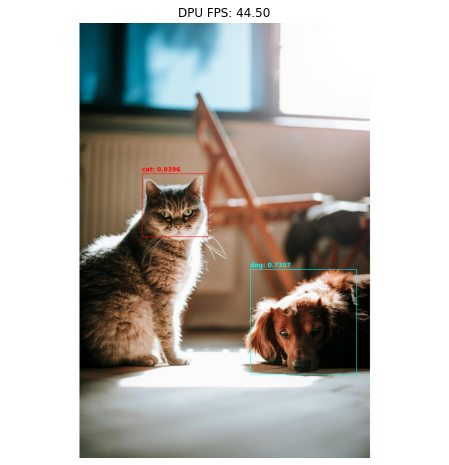

Number of detected objects: 2
DPU inference time: 0.0225 sec
DPU FPS: 44.50


In [12]:
def run(image_path, display=False):
     # Read image from disk (BGR format)
    input_image = cv2.imread(image_path)
    if input_image is None:
        raise FileNotFoundError(f"Failed to read image: {image_path}")

    # Run DPU inference and draw bounding boxes
    result_image, classes, dpu_time = dpu_process(input_image, draw=True, return_image=True)

    # Display result in Jupyter Notebook
    if display:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"DPU FPS: {1.0/dpu_time:.2f}" if dpu_time > 0 else "DPU FPS: Inf")
        plt.show()
        
    print("Number of detected objects:", len(classes))
    print(f"DPU inference time: {dpu_time:.4f} sec")
    print(f"DPU FPS: {1.0 / dpu_time:.2f}" if dpu_time > 0 else "DPU FPS: Inf")

    return result_image, classes

# ▶️ Example: run YOLOv5 inference on an image
run("img/img2.jpg", display=True);

### 🎥 Real-Time Video Inference in Jupyter

This function performs frame-by-frame inference on a local video file using the compiled YOLOv5 model on the DPU.  
It also displays real-time FPS (Frames Per Second) on the top-left of each frame.

Useful for:
- Demoing model performance on full videos
- Visualizing object detection results in a live, interactive Jupyter Notebook loop

> **Note:**  
> This runs in a continuous loop. To stop execution, click the **"Stop"** button (⏹) at the top of the Jupyter interface.


Stopped by user.


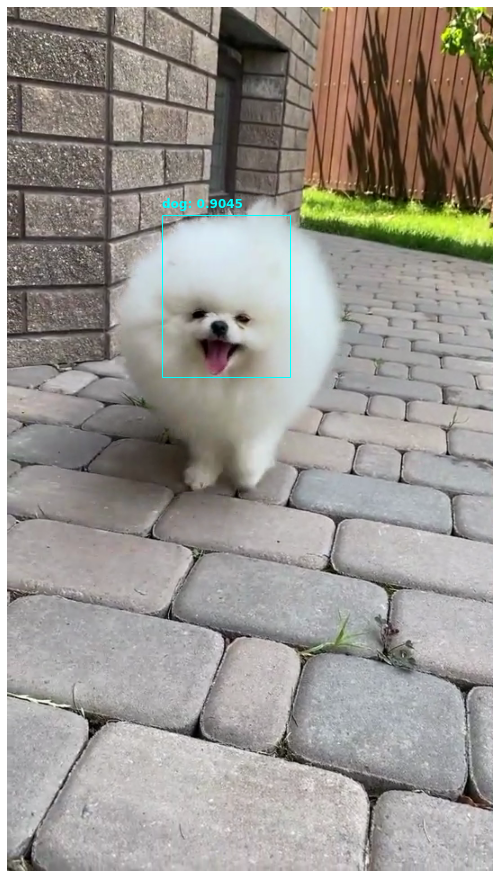

In [15]:
def runVideoLive(input_path):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Cannot open video: {input_path}")
        return

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Reached end of video.")
                break

            start_time = time.time()

            # Run YOLOv5 inference on current frame
            result_image, _, dpu_time = dpu_process(frame, draw=True, return_image=True)

            # Measure FPS
            fps_text = f"{1.0 / dpu_time:.2f} FPS" if dpu_time > 0 else "Inf FPS"

            # Draw FPS on top-left corner
            cv2.putText(result_image, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        1.0, (0, 0, 255), 2, cv2.LINE_AA)

            # Display frame in notebook
            _, ret_array = cv2.imencode('.jpg', result_image)
            img_disp = display.Image(data=ret_array)
            display.display(img_disp)
            display.clear_output(wait=True)

    except KeyboardInterrupt:
        print("Stopped by user.")
    finally:
        cap.release()
runVideoLive("video/demo.mp4")

### 📷 Real-Time Inference from Webcam

This function uses a connected webcam (usually at device index `0`) to stream frames in real time, process each frame with YOLOv5 on the DPU, and visualize the detection results inside the Jupyter Notebook.

Great for:
- Testing the live performance of the DPU model
- Doing quick object detection demos

> **Note:**  
> To stop the webcam stream, click the **"Stop" (⏹)** button at the top of the Jupyter interface.

Released Video Resource from KeyboardInterrupt.


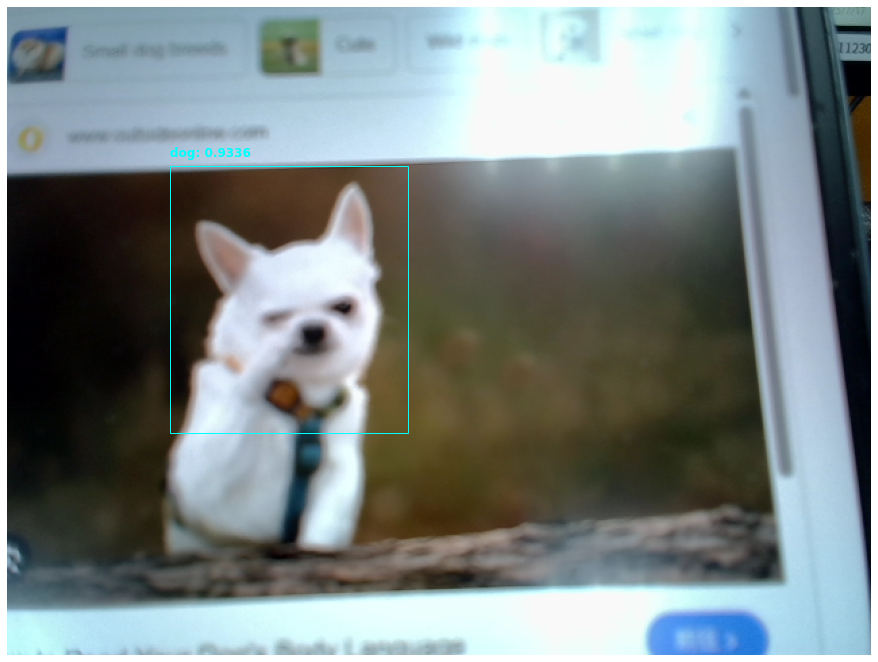

In [21]:
def runWebcam(device_index=0):
    try:
        cap = cv2.VideoCapture(device_index)
    except:
        print("Cannot Open Device.")
    try:
        ret, input_image = cap.read()
        
        while(ret==True):
            ret, input_image = cap.read()

            if not ret:
                cap.release()
                print ("Released Video Resource.")
                break
                
            # Run DPU inference and get timing
            output_image, classes, dpu_time = dpu_process(input_image) 
            
            # Calculate FPS from DPU time
            fps_text = f"{1.0 / dpu_time:.2f} FPS" if dpu_time > 0 else "Inf FPS"

            # Draw FPS on top-left corner
            cv2.putText(output_image, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        1.0, (0, 0, 255), 2, cv2.LINE_AA)
            
            # Display
            _,ret_array = cv2.imencode('.jpg', output_image) #this fixed the pipeline issue as the imshow was converting to png.
            i = display.Image(data=ret_array)
            display.display(i)
            display.clear_output(wait=True)

    except KeyboardInterrupt:
        print("Released Video Resource from KeyboardInterrupt.")
    finally:
        cap.release()
runWebcam(0)